William Albeiro Amaya Patiño

Realice el proceso de instalación de librerías requeridas para el desarrollo del modelo

In [1]:
import numpy as np
import pandas as pd
import random
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')  # Tokenizer
nltk.download('stopwords')  # Stopwords

## NLP - Procesamiento Natural del Lenguage

En este caso vamos a usar un conjunto de datos datos Diplomacy 

El conjunto de datos está disponible en :
(https://sites.google.com/view/qanta/projects/diplomacy?pli=1)


El archivo se encuentra en un formato específico con la extensión .json, por lo que vamos a necesitar algunas librerías adicionales para lectura de este formato.

### Lectura del archivo en formato json

In [ ]:
# Función para leer archivos jsonl y convertirlos en un DataFrame de pandas
def read_jsonl(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [ ]:
# Cargar los datos de entrenamiento, validación y prueba desde los archivos .jsonl
train_path = 'train.jsonl'
validation_path = 'validation.jsonl'
test_path = 'test.jsonl'

In [ ]:
train_df = read_jsonl(train_path)
validation_df = read_jsonl(validation_path)
test_df = read_jsonl(test_path)

#### Exploración general del conjunto de datos

El archivo cuenta con 13 columnas de información, en particular las de mas interés en este caso son messages que contiene los mensajes realizadas por los jugadores y sender_labels, la cual indica si el mensaje es confiable o mentiroso.

In [ ]:
train_df.shape

(189, 13)

In [ ]:
train_df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1



El objetivo es analizar cómo se comportan los jugadores que intercambian mensajes en el juego Diplomacy y cuál es la relación entre esos mensajes y la veracidad de los mismos.

Para lograr ese objetivo, lo primero que vamos a realizar es definir el valor para el cual se considera un mensaje como verdadero o falso. En este caso, las etiquetas en la variable sender_labels nos indican si un mensaje es verdadero o falso.

In [ ]:
# Función que verifica si hay un False en la lista de etiquetas
def contains_false(labels):
    return 1 if False in labels else 0

In [ ]:
# Aplicar la función a la columna sender_labels para crear la columna 'mentira'
train_df['mentira'] = train_df['sender_labels'].apply(contains_false)
validation_df['mentira'] = validation_df['sender_labels'].apply(contains_false)
test_df['mentira'] = test_df['sender_labels'].apply(contains_false)

In [ ]:
train_df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id,mentira
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1,1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1,1


In [ ]:
# Convertir mensajes a cadenas de texto si son listas
train_df['messages'] = train_df['messages'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
validation_df['messages'] = validation_df['messages'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
test_df['messages'] = test_df['messages'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [ ]:
train_df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id,mentira
0,Germany!\n\nJust the person I want to speak wi...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1,1
1,Hello there! What's your general plan for this...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1,1


# Análisis Exploratorio de Datos (EDA)

Para analizar mejor el conjunto de datos, se calculará la frecuencia de ocurrencia de mensajes etiquetados como verdaderos o falsos en la variable sender_labels, es decir, cuáles son las proporciones de mensajes en cada categoría.

### 1. Distribución de las clases

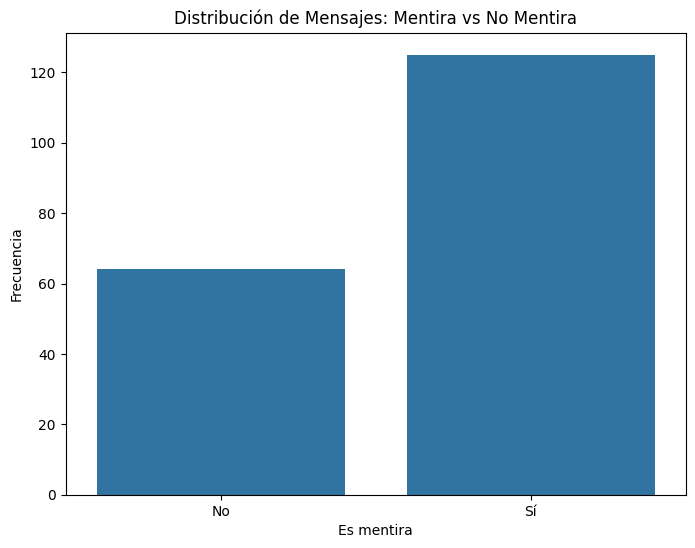

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='mentira', data=train_df)
plt.title('Distribución de Mensajes: Mentira vs No Mentira')
plt.xlabel('Es mentira')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

### 2. Estadísticas de la longitud de los mensajes

In [ ]:
train_df['messagelen'] = train_df['messages'].apply(len)
validation_df['messagelen'] = validation_df['messages'].apply(len)
test_df['messagelen'] = test_df['messages'].apply(len)

print("Estadísticas de la longitud de los mensajes en el conjunto de entrenamiento:")
print(train_df['messagelen'].describe())
print("\nEstadísticas de la longitud de los mensajes en el conjunto de validación:")
print(validation_df['messagelen'].describe())
print("\nEstadísticas de la longitud de los mensajes en el conjunto de prueba:")
print(test_df['messagelen'].describe())

Estadísticas de la longitud de los mensajes en el conjunto de entrenamiento:
count       189.000000
mean       7538.412698
std       12118.347932
min           0.000000
25%         884.000000
50%        3055.000000
75%        8285.000000
max      100047.000000
Name: messagelen, dtype: float64

Estadísticas de la longitud de los mensajes en el conjunto de validación:
count       21.000000
mean      6407.000000
std       7781.356829
min          0.000000
25%       1200.000000
50%       2918.000000
75%      10829.000000
max      25391.000000
Name: messagelen, dtype: float64

Estadísticas de la longitud de los mensajes en el conjunto de prueba:
count       42.000000
mean      6533.309524
std       9056.216015
min        187.000000
25%        888.500000
50%       2140.000000
75%       9073.500000
max      38979.000000
Name: messagelen, dtype: float64


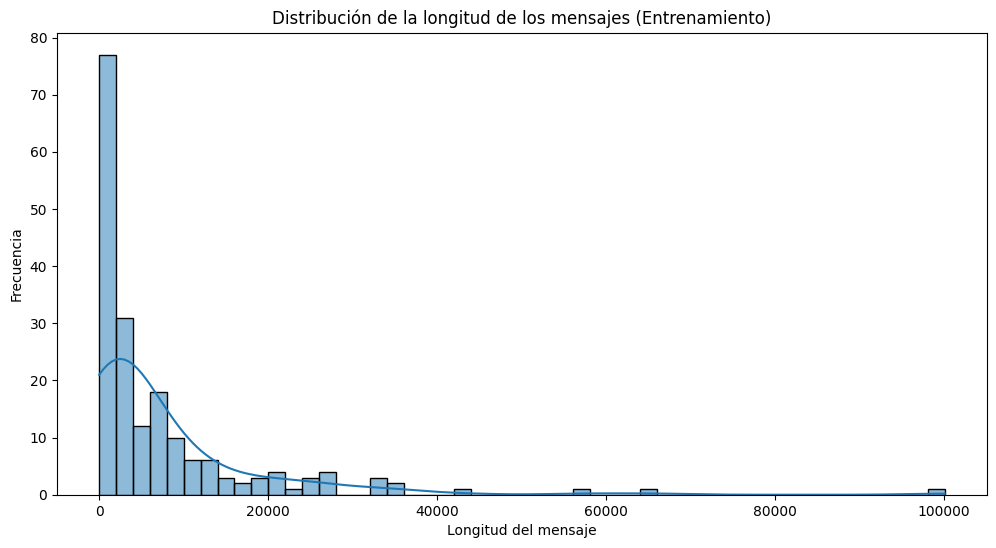

In [ ]:
# Histograma de la longitud de los mensajes
plt.figure(figsize=(12, 6))
sns.histplot(train_df['messagelen'], bins=50, kde=True)
plt.title('Distribución de la longitud de los mensajes (Entrenamiento)')
plt.xlabel('Longitud del mensaje')
plt.ylabel('Frecuencia')
plt.show()

### 3. Palabras más comunes

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

train_df['tokenized_messages'] = train_df['messages'].apply(preprocess_text)

In [ ]:
# Contar las palabras más comunes
all_words = [word for tokens in train_df['tokenized_messages'] for word in tokens]
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

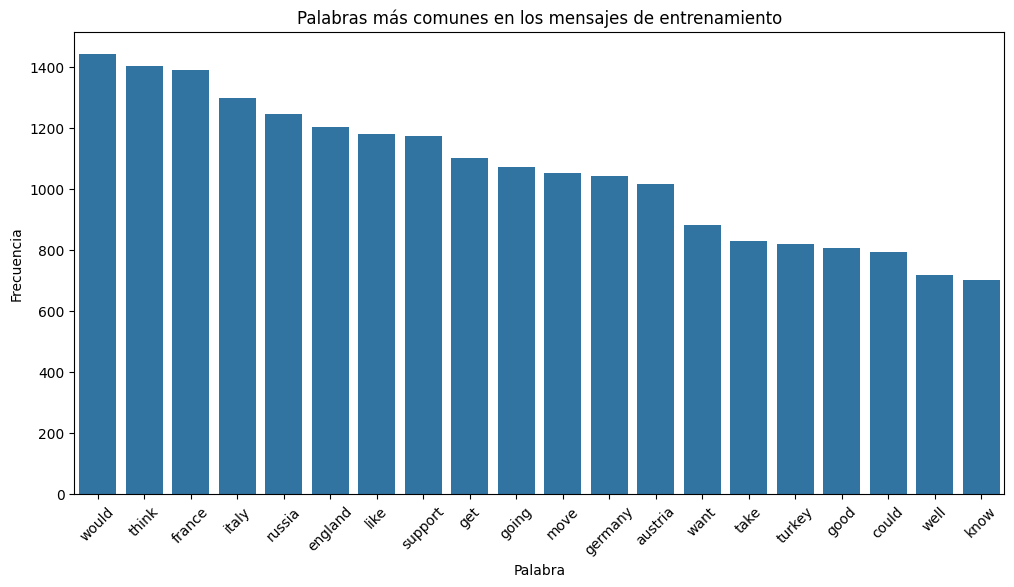

In [ ]:
# Mostrar las palabras más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Palabras más comunes en los mensajes de entrenamiento')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

### 4. Nube de palabras

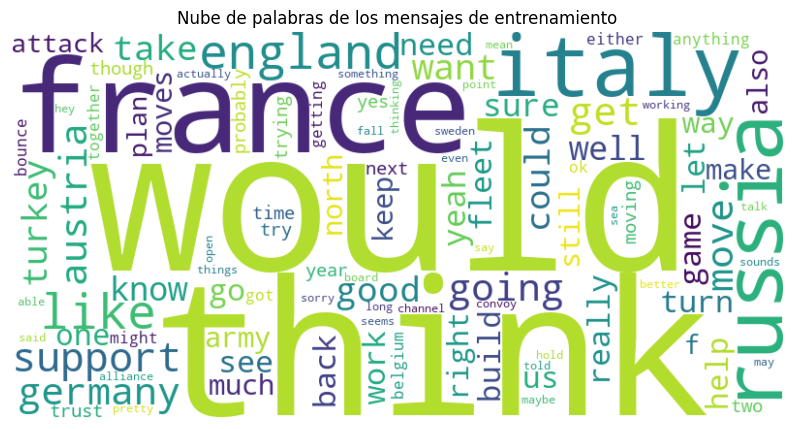

In [ ]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nube de palabras de los mensajes de entrenamiento')
plt.axis('off')
plt.show()

# Inicializar el tokenizer de BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
tokenizer.tokenize("My dog lover strawberries.")


['my', 'dog', 'lover', 'straw', '##berries', '.']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("My dog lover strawberries."))


[2026, 3899, 7089, 13137, 20968, 1012]

# Función para tokenizar los datos

In [ ]:
def tokenize_data(df):
    return tokenizer(df['messages'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')


# Tokenizar los datos de entrenamiento, validación y prueba

In [ ]:
train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(validation_df)
test_encodings = tokenize_data(test_df)

In [ ]:
train_encodings


{'input_ids': tensor([[  101,  2762,   999,  ...,  3304,  1012,   102],
        [  101,  7592,  2045,  ...,  1045,  2323,   102],
        [  101, 20934,  5063,  ...,  2078,  3467,   102],
        ...,
        [  101,  4931,  7592,  ...,     0,     0,     0],
        [  101,  7592,  2605,  ...,  2215,  3304,   102],
        [  101,   102,     0,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 0, 0, 0]])}

# Clase personalizada para manejar el dataset tokenizado

In [ ]:
class DiplomacyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Crear los datasets de entrenamiento, validación y prueba

In [ ]:
train_dataset = DiplomacyDataset(train_encodings, train_df['mentira'].tolist())
val_dataset = DiplomacyDataset(val_encodings, validation_df['mentira'].tolist())
test_dataset = DiplomacyDataset(test_encodings, test_df['mentira'].tolist())

# Inicializar el modelo BERT para clasificación de secuencias

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Definir los argumentos del entrenamiento

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,              # Aumentar el número de épocas a 10
    per_device_train_batch_size=32,   # Aumentar el tamaño del lote de entrenamiento a 32
    per_device_eval_batch_size=32,    # Aumentar el tamaño del lote de evaluación a 32
    warmup_steps=1000,                # Aumentar los pasos de calentamiento a 1000
    weight_decay=0.1,                 # Aumentar el decaimiento del peso a 0.1
    logging_dir='./logs',             # Directorio para guardar los logs
    logging_steps=10,                 # Intervalo de pasos para logging
    evaluation_strategy="epoch",      # Evaluar al final de cada época
    save_strategy="epoch",            # Guardar al final de cada época
    learning_rate=3e-5,               # Ajustar la tasa de aprendizaje a 3e-5
    save_total_limit=3,               # Limitar el número de checkpoints guardados a 3
    load_best_model_at_end=True,      # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model='eval_loss' # Métrica para seleccionar el mejor modelo: pérdida de evaluación
)

c:\Users\eusou\AppData\Local\R-MINI~1\envs\BIG_DATA_2023\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Definir una función de evaluación personalizada

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Inicializar el Trainer de Hugging Face

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Entrenar el modelo

In [ ]:
trainer.train()

 10%|█         | 6/60 [01:45<14:45, 16.39s/it]

{'eval_loss': 0.5340663194656372, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 4.0315, 'eval_samples_per_second': 5.209, 'eval_steps_per_second': 0.248, 'epoch': 1.0}


 17%|█▋        | 10/60 [02:53<14:06, 16.92s/it]

{'loss': 0.4218, 'grad_norm': 4.398845195770264, 'learning_rate': 3.0000000000000004e-07, 'epoch': 1.67}


 20%|██        | 12/60 [03:27<12:54, 16.13s/it]

{'eval_loss': 0.5371520519256592, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 3.6149, 'eval_samples_per_second': 5.809, 'eval_steps_per_second': 0.277, 'epoch': 2.0}


 30%|███       | 18/60 [05:08<11:29, 16.42s/it]

{'eval_loss': 0.5455429553985596, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 3.5349, 'eval_samples_per_second': 5.941, 'eval_steps_per_second': 0.283, 'epoch': 3.0}


 33%|███▎      | 20/60 [05:42<11:33, 17.34s/it]

{'loss': 0.4161, 'grad_norm': 4.671926498413086, 'learning_rate': 6.000000000000001e-07, 'epoch': 3.33}


 40%|████      | 24/60 [06:51<09:50, 16.42s/it]

{'eval_loss': 0.5555145144462585, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 3.8932, 'eval_samples_per_second': 5.394, 'eval_steps_per_second': 0.257, 'epoch': 4.0}


 50%|█████     | 30/60 [08:32<08:14, 16.49s/it]

{'loss': 0.3968, 'grad_norm': 4.377610206604004, 'learning_rate': 9e-07, 'epoch': 5.0}



 50%|█████     | 30/60 [08:36<08:14, 16.49s/it]

{'eval_loss': 0.5550677180290222, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 3.9608, 'eval_samples_per_second': 5.302, 'eval_steps_per_second': 0.252, 'epoch': 5.0}


 60%|██████    | 36/60 [10:19<06:27, 16.15s/it]

{'eval_loss': 0.5514390468597412, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 3.7557, 'eval_samples_per_second': 5.592, 'eval_steps_per_second': 0.266, 'epoch': 6.0}


 67%|██████▋   | 40/60 [11:27<05:43, 17.18s/it]

{'loss': 0.3818, 'grad_norm': 5.064565658569336, 'learning_rate': 1.2000000000000002e-06, 'epoch': 6.67}


 70%|███████   | 42/60 [12:02<04:51, 16.20s/it]

{'eval_loss': 0.5523644685745239, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 3.529, 'eval_samples_per_second': 5.951, 'eval_steps_per_second': 0.283, 'epoch': 7.0}


 80%|████████  | 48/60 [13:48<03:23, 16.98s/it]

{'eval_loss': 0.5584307312965393, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 4.6711, 'eval_samples_per_second': 4.496, 'eval_steps_per_second': 0.214, 'epoch': 8.0}


 83%|████████▎ | 50/60 [14:25<03:05, 18.52s/it]

{'loss': 0.3874, 'grad_norm': 5.25032901763916, 'learning_rate': 1.5e-06, 'epoch': 8.33}


 90%|█████████ | 54/60 [15:37<01:42, 17.10s/it]

{'eval_loss': 0.5615917444229126, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 3.8718, 'eval_samples_per_second': 5.424, 'eval_steps_per_second': 0.258, 'epoch': 9.0}


100%|██████████| 60/60 [17:21<00:00, 17.31s/it]

{'loss': 0.3783, 'grad_norm': 6.331679344177246, 'learning_rate': 1.8e-06, 'epoch': 10.0}



100%|██████████| 60/60 [17:27<00:00, 17.31s/it]

{'eval_loss': 0.5605286955833435, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 4.1411, 'eval_samples_per_second': 5.071, 'eval_steps_per_second': 0.241, 'epoch': 10.0}


100%|██████████| 60/60 [17:29<00:00, 17.50s/it]

{'train_runtime': 1049.861, 'train_samples_per_second': 1.8, 'train_steps_per_second': 0.057, 'train_loss': 0.39702455202738446, 'epoch': 10.0}


TrainOutput(global_step=60, training_loss=0.39702455202738446, metrics={'train_runtime': 1049.861, 'train_samples_per_second': 1.8, 'train_steps_per_second': 0.057, 'total_flos': 124319973657600.0, 'train_loss': 0.39702455202738446, 'epoch': 10.0})

# Evaluar el modelo en el conjunto de validación

In [ ]:
results = trainer.evaluate()
print(results)

100%|██████████| 1/1 [00:00<00:00, 19.54it/s]

{'eval_loss': 0.5340663194656372, 'eval_accuracy': 0.7619047619047619, 'eval_f1': 0.8484848484848484, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_runtime': 5.6416, 'eval_samples_per_second': 3.722, 'eval_steps_per_second': 0.177, 'epoch': 10.0}


# Evaluar el modelo en el conjunto de prueba

In [ ]:
test_results = trainer.predict(test_dataset)
print(test_results)

100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

PredictionOutput(predictions=array([[-0.9252259 ,  0.51204485],
       [-0.7587834 ,  0.32687083],
       [-0.46171862, -0.25605208],
       [-0.37561625, -0.5186362 ],
       [-1.0288728 ,  0.5578647 ],
       [-1.2130301 ,  0.8368167 ],
       [-0.7044929 ,  0.06963698],
       [-0.6423455 , -0.00347759],
       [-0.85816115,  0.5122023 ],
       [-0.9587795 ,  0.58185595],
       [-0.7590337 ,  0.26259595],
       [-1.184225  ,  0.87562907],
       [-0.34602875, -0.454472  ],
       [-0.40026486, -0.32766676],
       [-0.3250545 , -0.4192152 ],
       [-1.3740308 ,  1.0039932 ],
       [-0.54445285, -0.14654644],
       [-1.2178612 ,  1.0388823 ],
       [-0.5530963 ,  0.4551086 ],
       [-0.97512925,  1.033105  ],
       [-0.58503574,  0.3363582 ],
       [-0.63876605, -0.06699594],
       [-0.52733177, -0.12703834],
       [-0.7261818 ,  0.194989  ],
       [-0.84801835,  0.13409321],
       [-0.82991713,  0.56452745],
       [-0.97846836,  0.75865465],
       [-0.83773583,  0.27